In [1]:
%matplotlib notebook

### Import bibliotek

In [2]:
import os
import numpy as np
import rasterio as rio
import rasterio.mask as rmask
import fiona as fio
import matplotlib.pyplot as plt

### Funkcja wczytująca adresy plików do przetworzenia

In [3]:
def read_landsat_images(folder_name):
    """Funkcja zwraca słownik (dict) z parami NUMER KANAŁU: ścieżka_do_pliku
    return: {numer_kanalu: sciezka_do_pliku}"""
    file_list = os.listdir(folder_name)
    channel_list = []
    for f in file_list:
        if (f.startswith('LC') and f.endswith('.tif')):
            if 'band' in f:
                channel_list.append(folder_name + f)             
    channel_list.sort()
    channel_numbers = np.arange(1, 8)
    bands_dictionary = dict(zip(channel_numbers, channel_list))
    return bands_dictionary

# Test
satellite_images = read_landsat_images('LC081880252013080701T1-SC20180329040242/')
for band in satellite_images:
    print(band, satellite_images[band])

1 LC081880252013080701T1-SC20180329040242/LC08_L1TP_188025_20130807_20170503_01_T1_sr_band1.tif
2 LC081880252013080701T1-SC20180329040242/LC08_L1TP_188025_20130807_20170503_01_T1_sr_band2.tif
3 LC081880252013080701T1-SC20180329040242/LC08_L1TP_188025_20130807_20170503_01_T1_sr_band3.tif
4 LC081880252013080701T1-SC20180329040242/LC08_L1TP_188025_20130807_20170503_01_T1_sr_band4.tif
5 LC081880252013080701T1-SC20180329040242/LC08_L1TP_188025_20130807_20170503_01_T1_sr_band5.tif
6 LC081880252013080701T1-SC20180329040242/LC08_L1TP_188025_20130807_20170503_01_T1_sr_band6.tif
7 LC081880252013080701T1-SC20180329040242/LC08_L1TP_188025_20130807_20170503_01_T1_sr_band7.tif


### Funkcja do wyświetlania obrazów

<IPython.core.display.Javascript object>


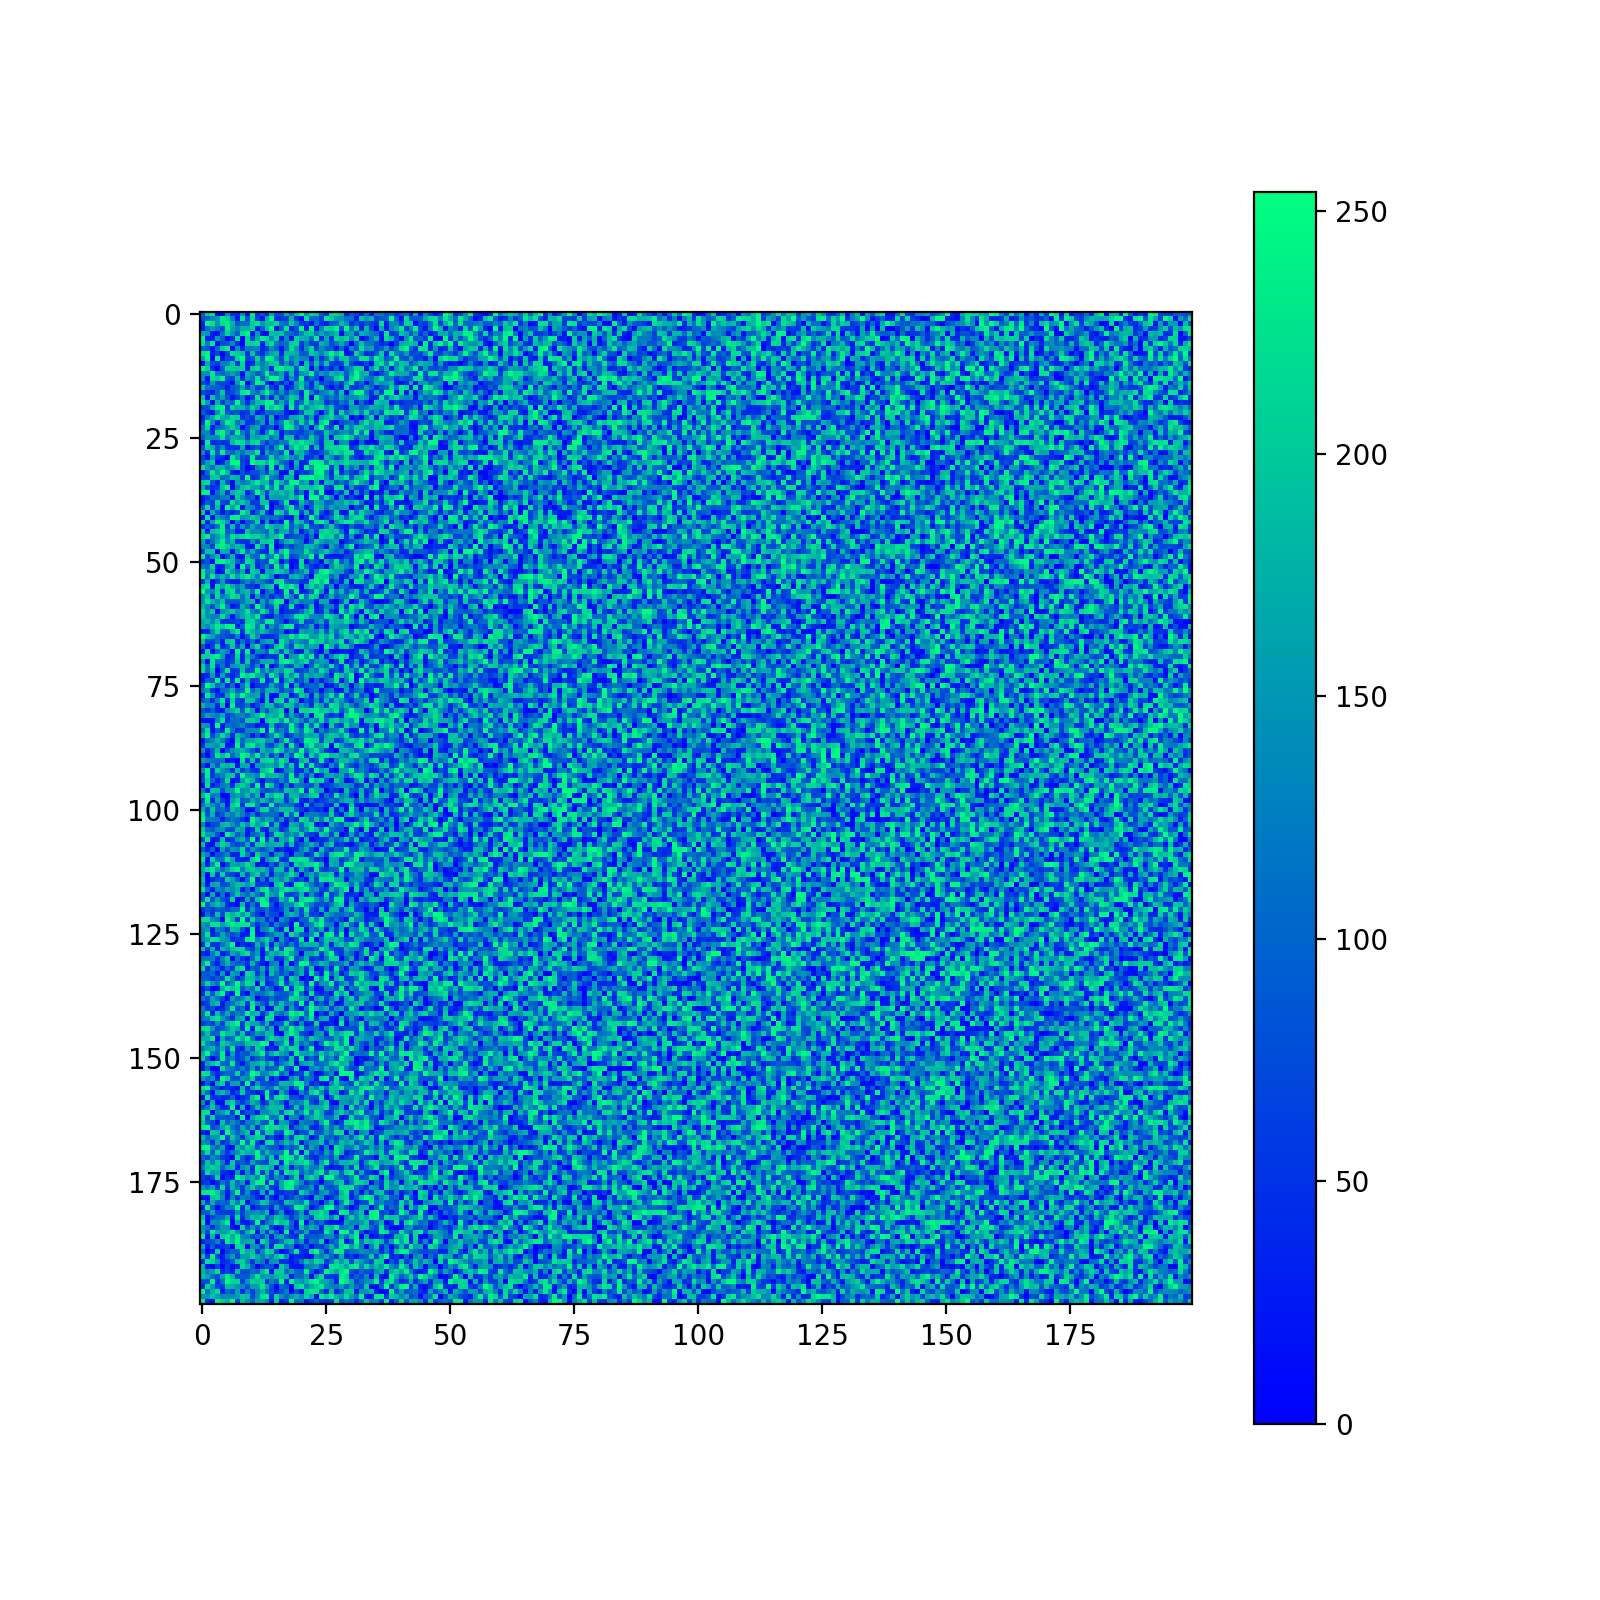

In [4]:
def show_band(band, color_map='gray'):
    fig = plt.figure(figsize=(8,8))
    image_layer = plt.imshow(band)
    image_layer.set_cmap(color_map)
    plt.colorbar()
    plt.show()
    
# Test
test = np.random.randint(low=0, high=255, size=(200, 200))
show_band(test, color_map='winter')

### Wczytanie listy dostępnych kanałów i wyświetlenie przykładowego obrazu

<IPython.core.display.Javascript object>


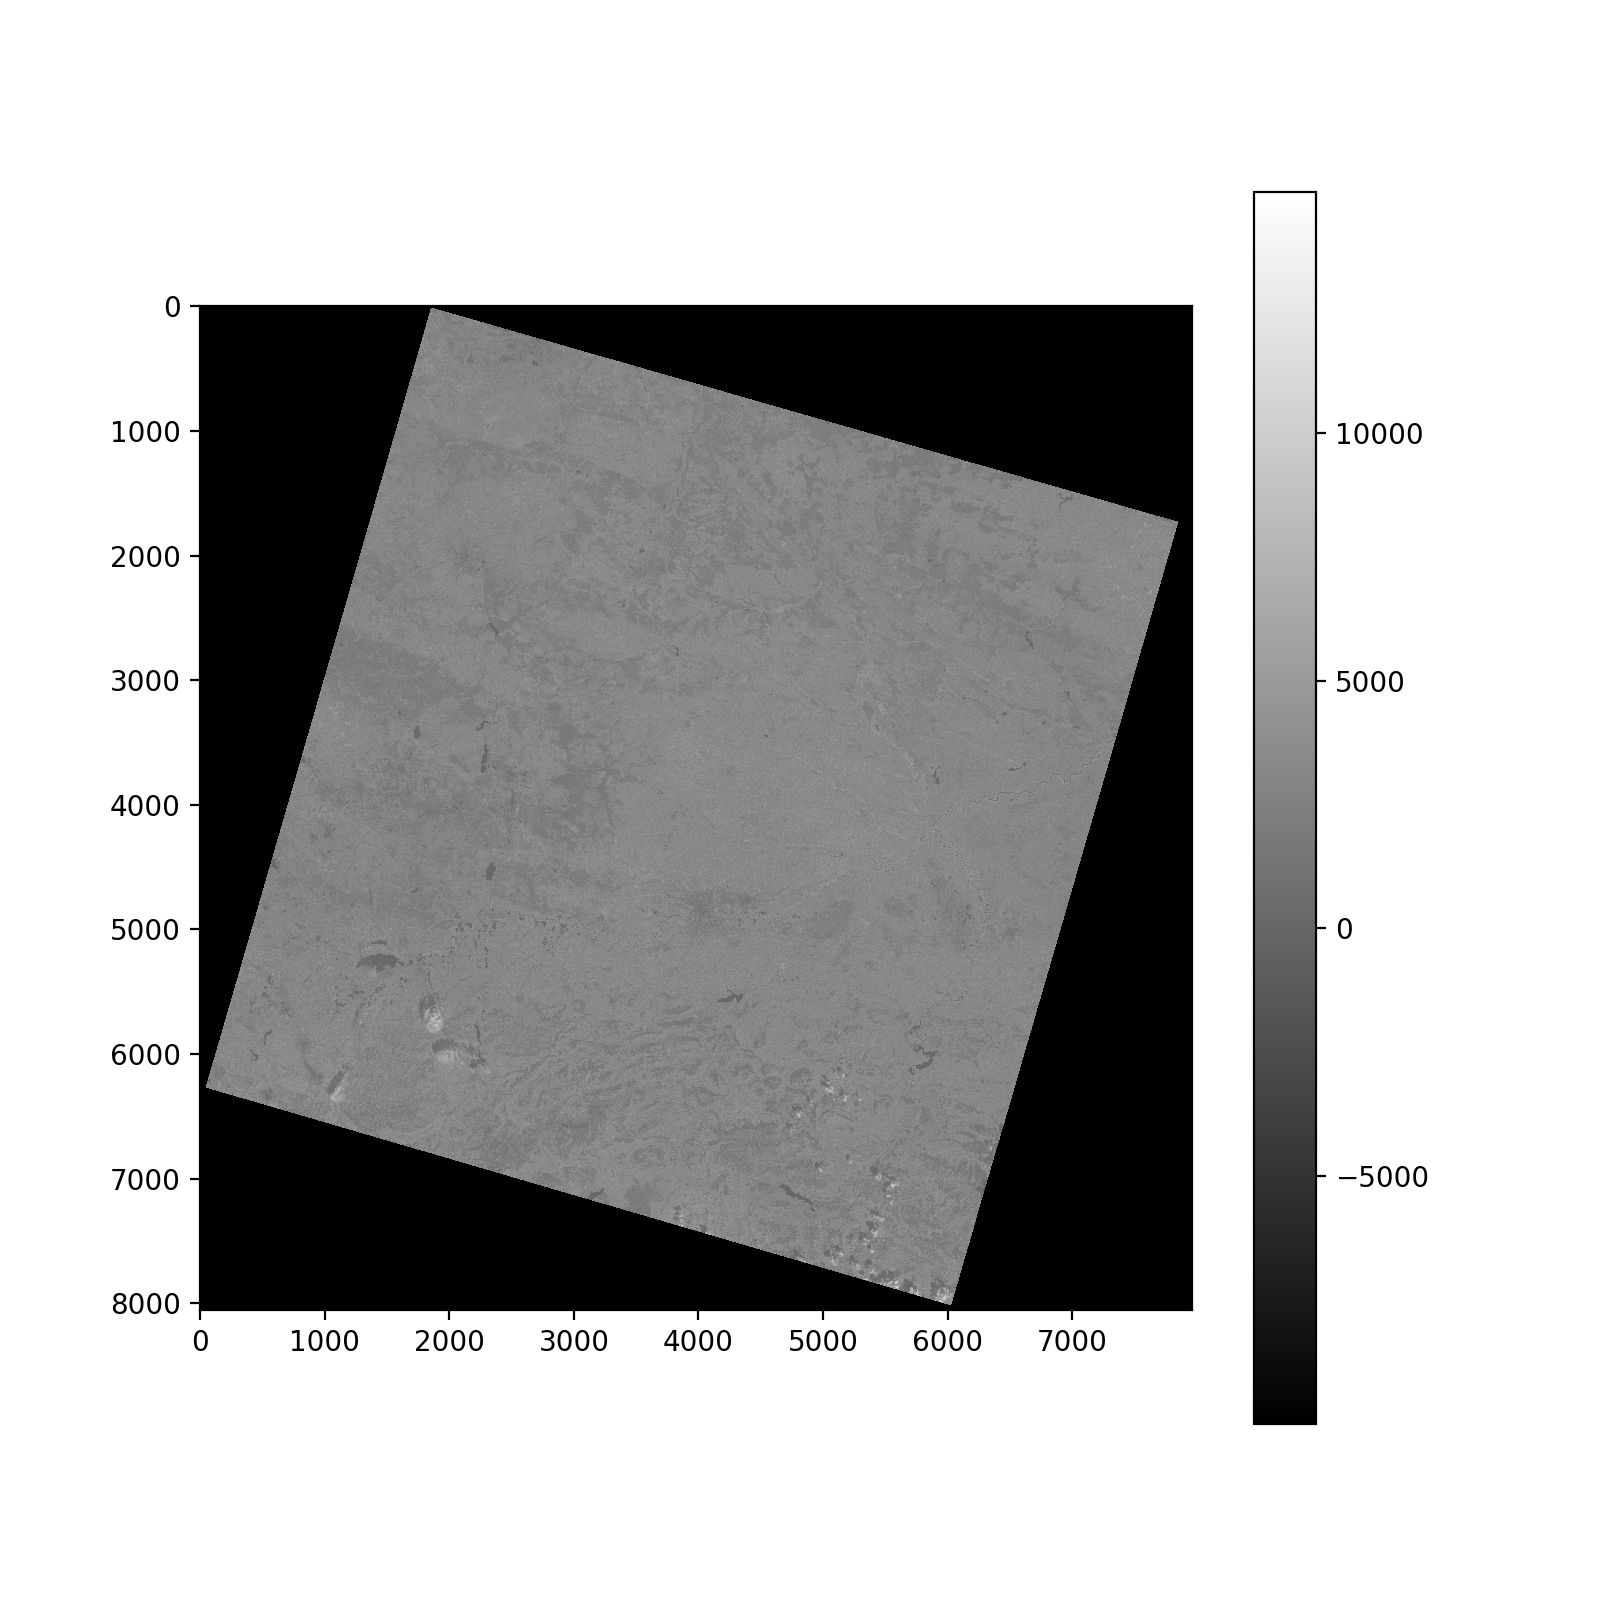

In [5]:
band_list = read_landsat_images('LC081880252013080701T1-SC20180329040242/')

with rio.open(band_list[5], 'r') as src:
    band_matrix = src.read(1)
    
show_band(band_matrix)

### Usunięcie wartości oznaczających brak danych, poprawa funkcji do wyświetlania obrazów

<IPython.core.display.Javascript object>


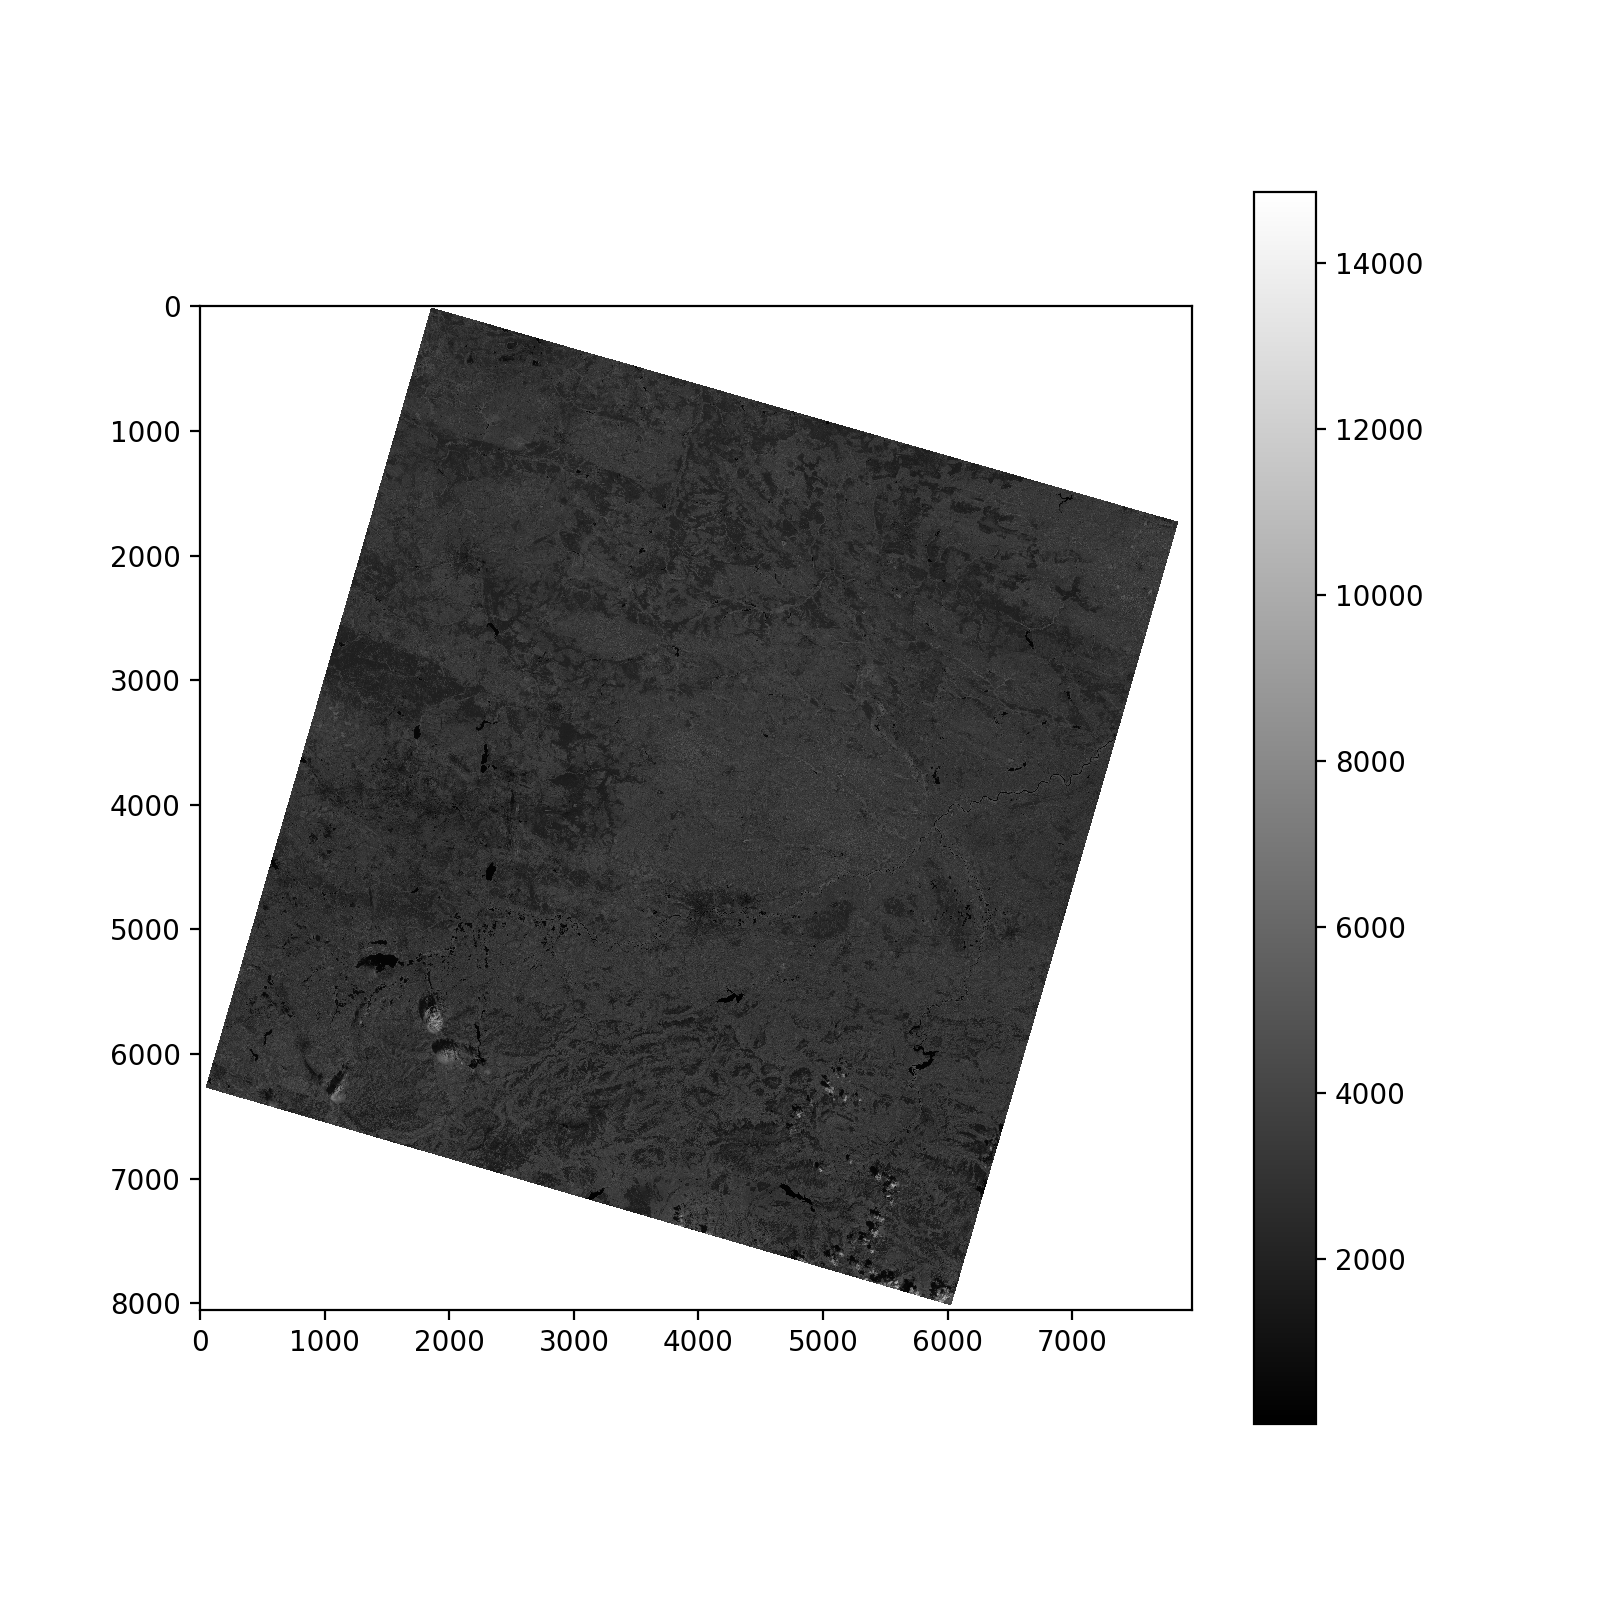

In [6]:
def show_band(band, color_map='gray', remove_negative=True):
    matrix = band.astype(float)
    if remove_negative:
        matrix[matrix <= 0] = np.nan
    fig = plt.figure(figsize=(8,8))
    image_layer = plt.imshow(matrix)
    image_layer.set_cmap(color_map)
    plt.colorbar()
    plt.show()
    
show_band(band_matrix)

### Wycięcie obszaru zainteresowania z rastra

In [7]:
def clip_area(vector_file, raster_file, save_image_to):

    with fio.open(vector_file, 'r') as clipper:
        geometry = [feature["geometry"] for feature in clipper]

    with rio.open(raster_file, 'r') as raster_source:
        clipped_image, transform = rmask.mask(raster_source, geometry, crop=True)
        metadata = raster_source.meta.copy()
        
    metadata.update({"driver": "GTiff",
                 "height": clipped_image.shape[1],
                 "width": clipped_image.shape[2],
                 "transform": transform})
    with rio.open(save_image_to, "w", **metadata) as g_tiff:
        g_tiff.write(clipped_image)

### Przetworzenie rastrów do postaci obejmującej obszar zainteresowań

In [8]:
# 1. Wczytanie plików obrazów i sporządzenie ich listy

bands = read_landsat_images('LC081880252013080701T1-SC20180329040242/')

In [9]:
# 2. Wycięcie obszaru zainteresowania z każdego pliku

vector = 'vector/krakow_krakowskie.shp'
clipped_folder = 'clipped/'
for band in bands:
    destination = clipped_folder + 'LC_clipped_band' + str(band) + '.tif'
    clip_area(vector, bands[band], destination)

In [10]:
# 3. Wczytanie listy przetworzonych plików

clipped_bands = read_landsat_images('clipped/')
for band in clipped_bands:
    print(clipped_bands[band])

clipped/LC_clipped_band1.tif
clipped/LC_clipped_band2.tif
clipped/LC_clipped_band3.tif
clipped/LC_clipped_band4.tif
clipped/LC_clipped_band5.tif
clipped/LC_clipped_band6.tif
clipped/LC_clipped_band7.tif


<IPython.core.display.Javascript object>


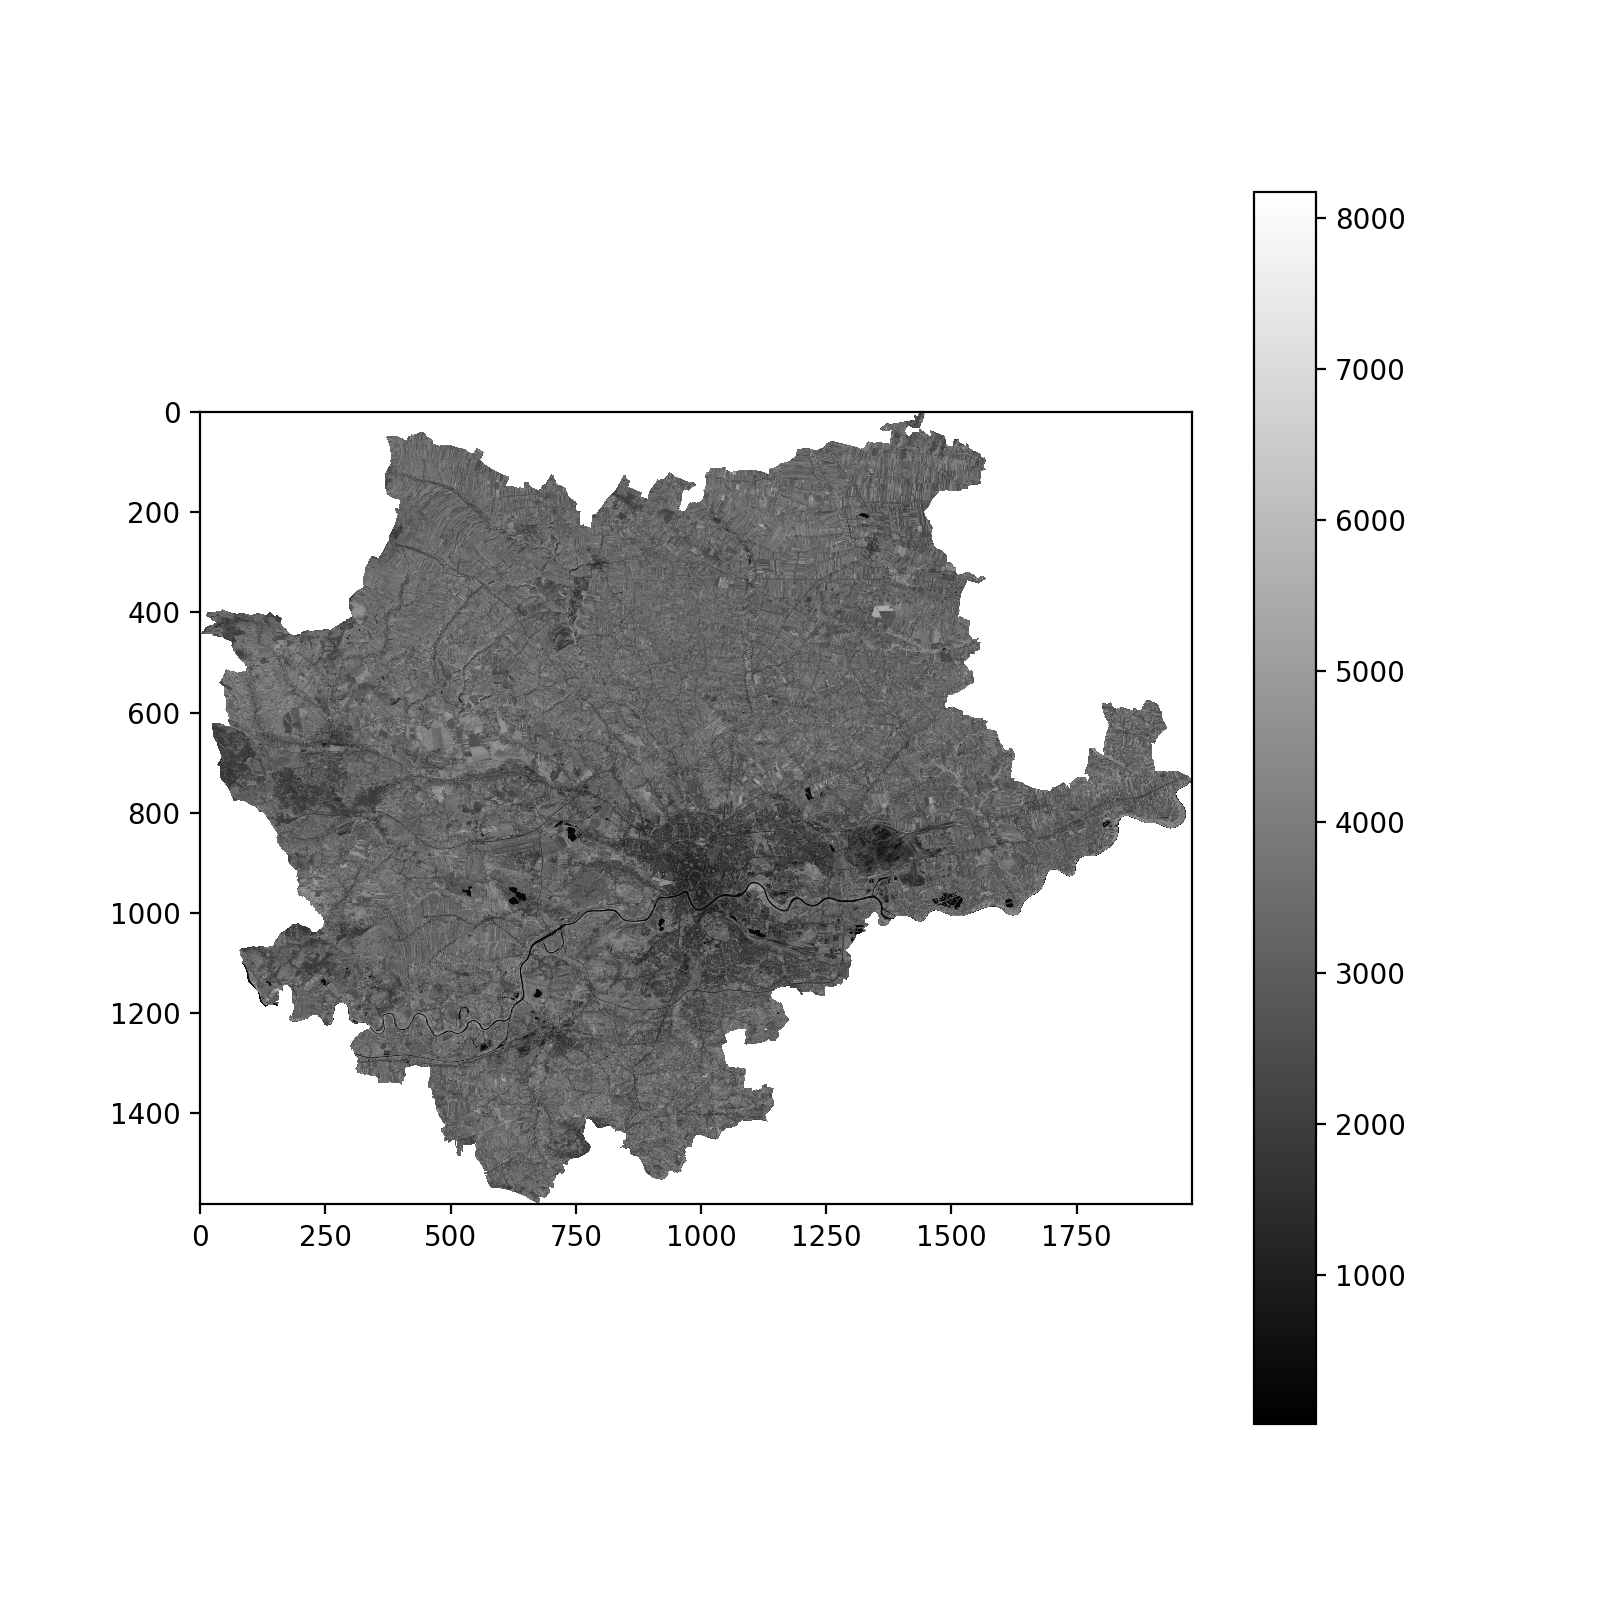

In [11]:
# 4. Wyświetlenie przykładowego pliku

with rio.open(clipped_bands[5], 'r') as src:
    band_matrix = src.read(1)
    
show_band(band_matrix)

### Wskaźniki, które można pozyskać z danych satelitarnych

In [12]:
def calculate_index(index_name, landsat_8_bands):
    indexes = {
        'ndvi': (5, 4),
        'ndbi': (6, 5),
        'ndwi': (3, 6),
    }
    
    # Magiczne 10000 przez które dzielone są piksele poszczególnych obrazów
    # to maksymalna wartość pikseli w produktach poziomu 2 satelity Landsat 8
    
    if index_name in indexes:
        bands = indexes[index_name]
        
        with rio.open(landsat_8_bands[bands[0]]) as a:
            band_a = (a.read()[0]/10000).astype(np.float)
        with rio.open(landsat_8_bands[bands[1]]) as b:
            band_b = (b.read()[0]/10000).astype(np.float)
        
        numerator = band_a - band_b
        denominator = band_a + band_b
        
        idx = numerator / denominator
        idx[idx > 1] = 1
        idx[idx < -1] = -1
        return idx
    else:
        raise ValueError('Brak wskaźnika do wyboru, dostępne wskaźniki to ndbi, ndvi i ndwi')

<IPython.core.display.Javascript object>


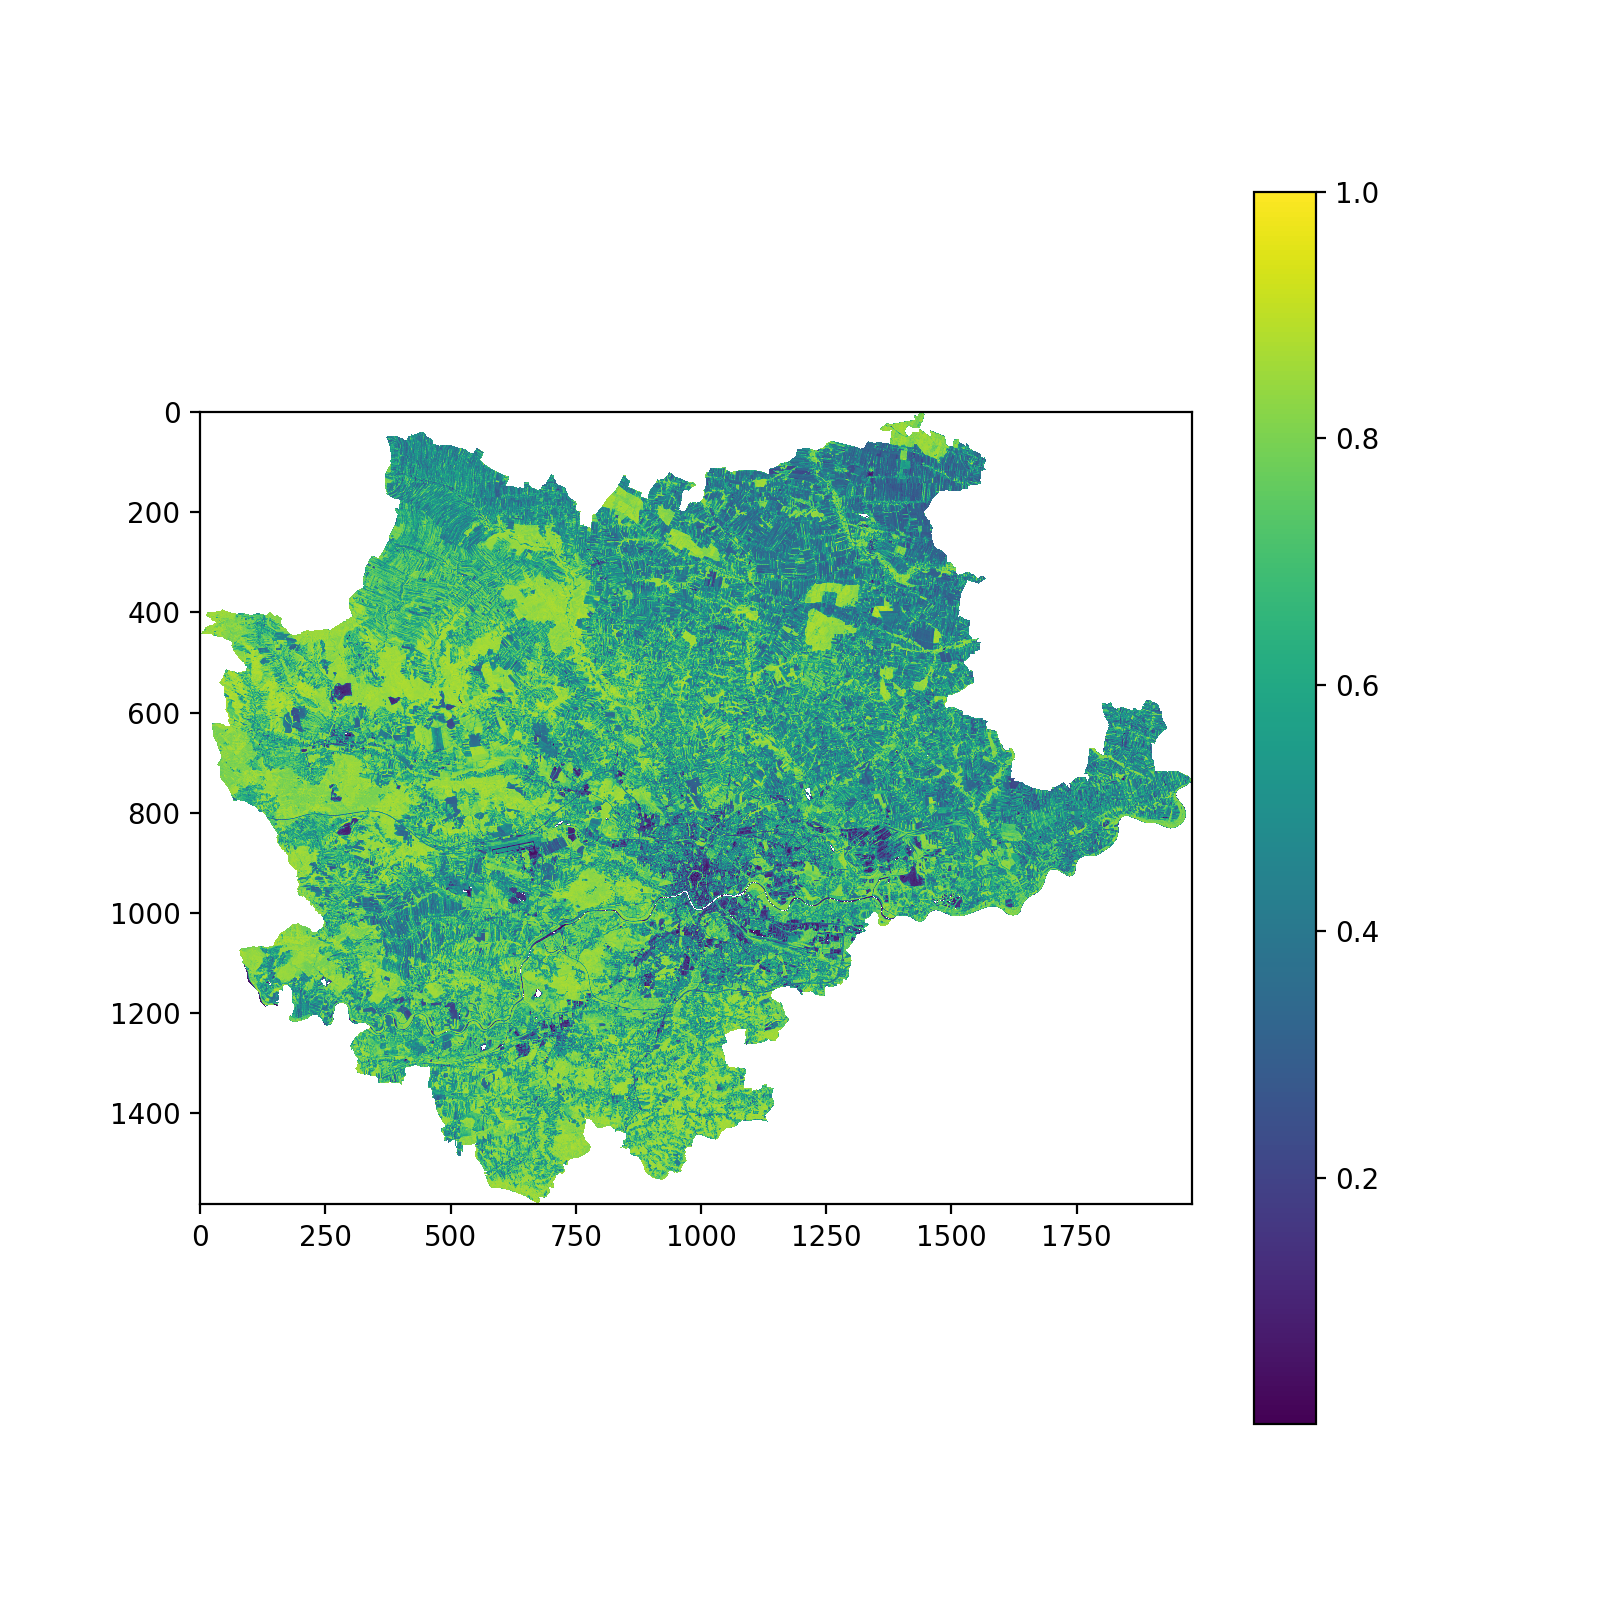

In [13]:
# 5. Oblicz NDVI

ndvi = calculate_index('ndvi', clipped_bands)
ndvi[ndvi == 0] = -1
show_band(ndvi, color_map='viridis', remove_negative=True)

<IPython.core.display.Javascript object>


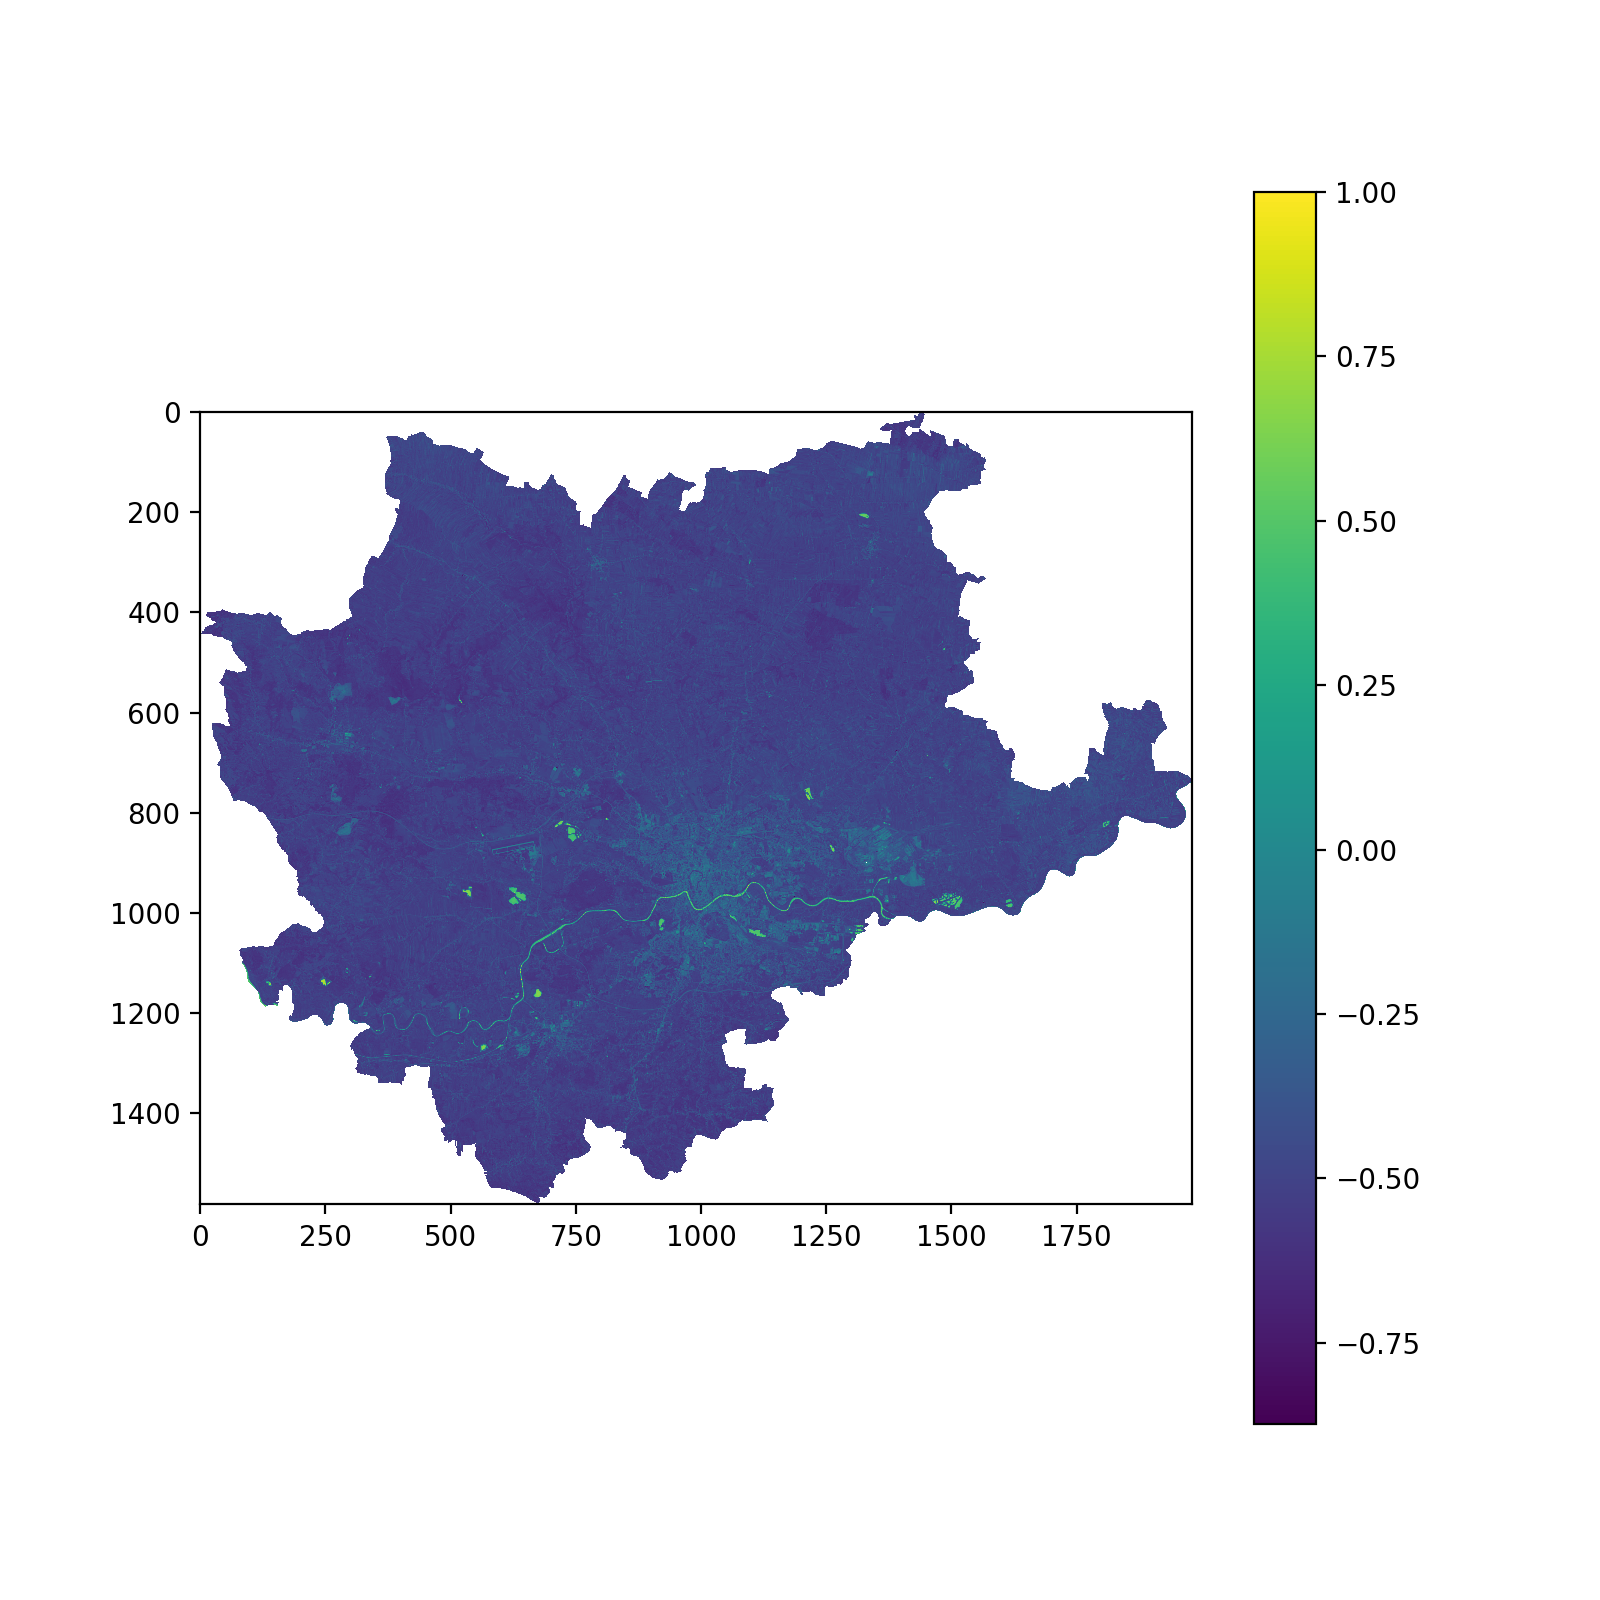

In [14]:
# 6. Oblicz NDWI

ndwi = calculate_index('ndwi', clipped_bands)
ndwi[ndwi == 0] = np.nan
show_band(ndwi, color_map='viridis', remove_negative=False)

<IPython.core.display.Javascript object>


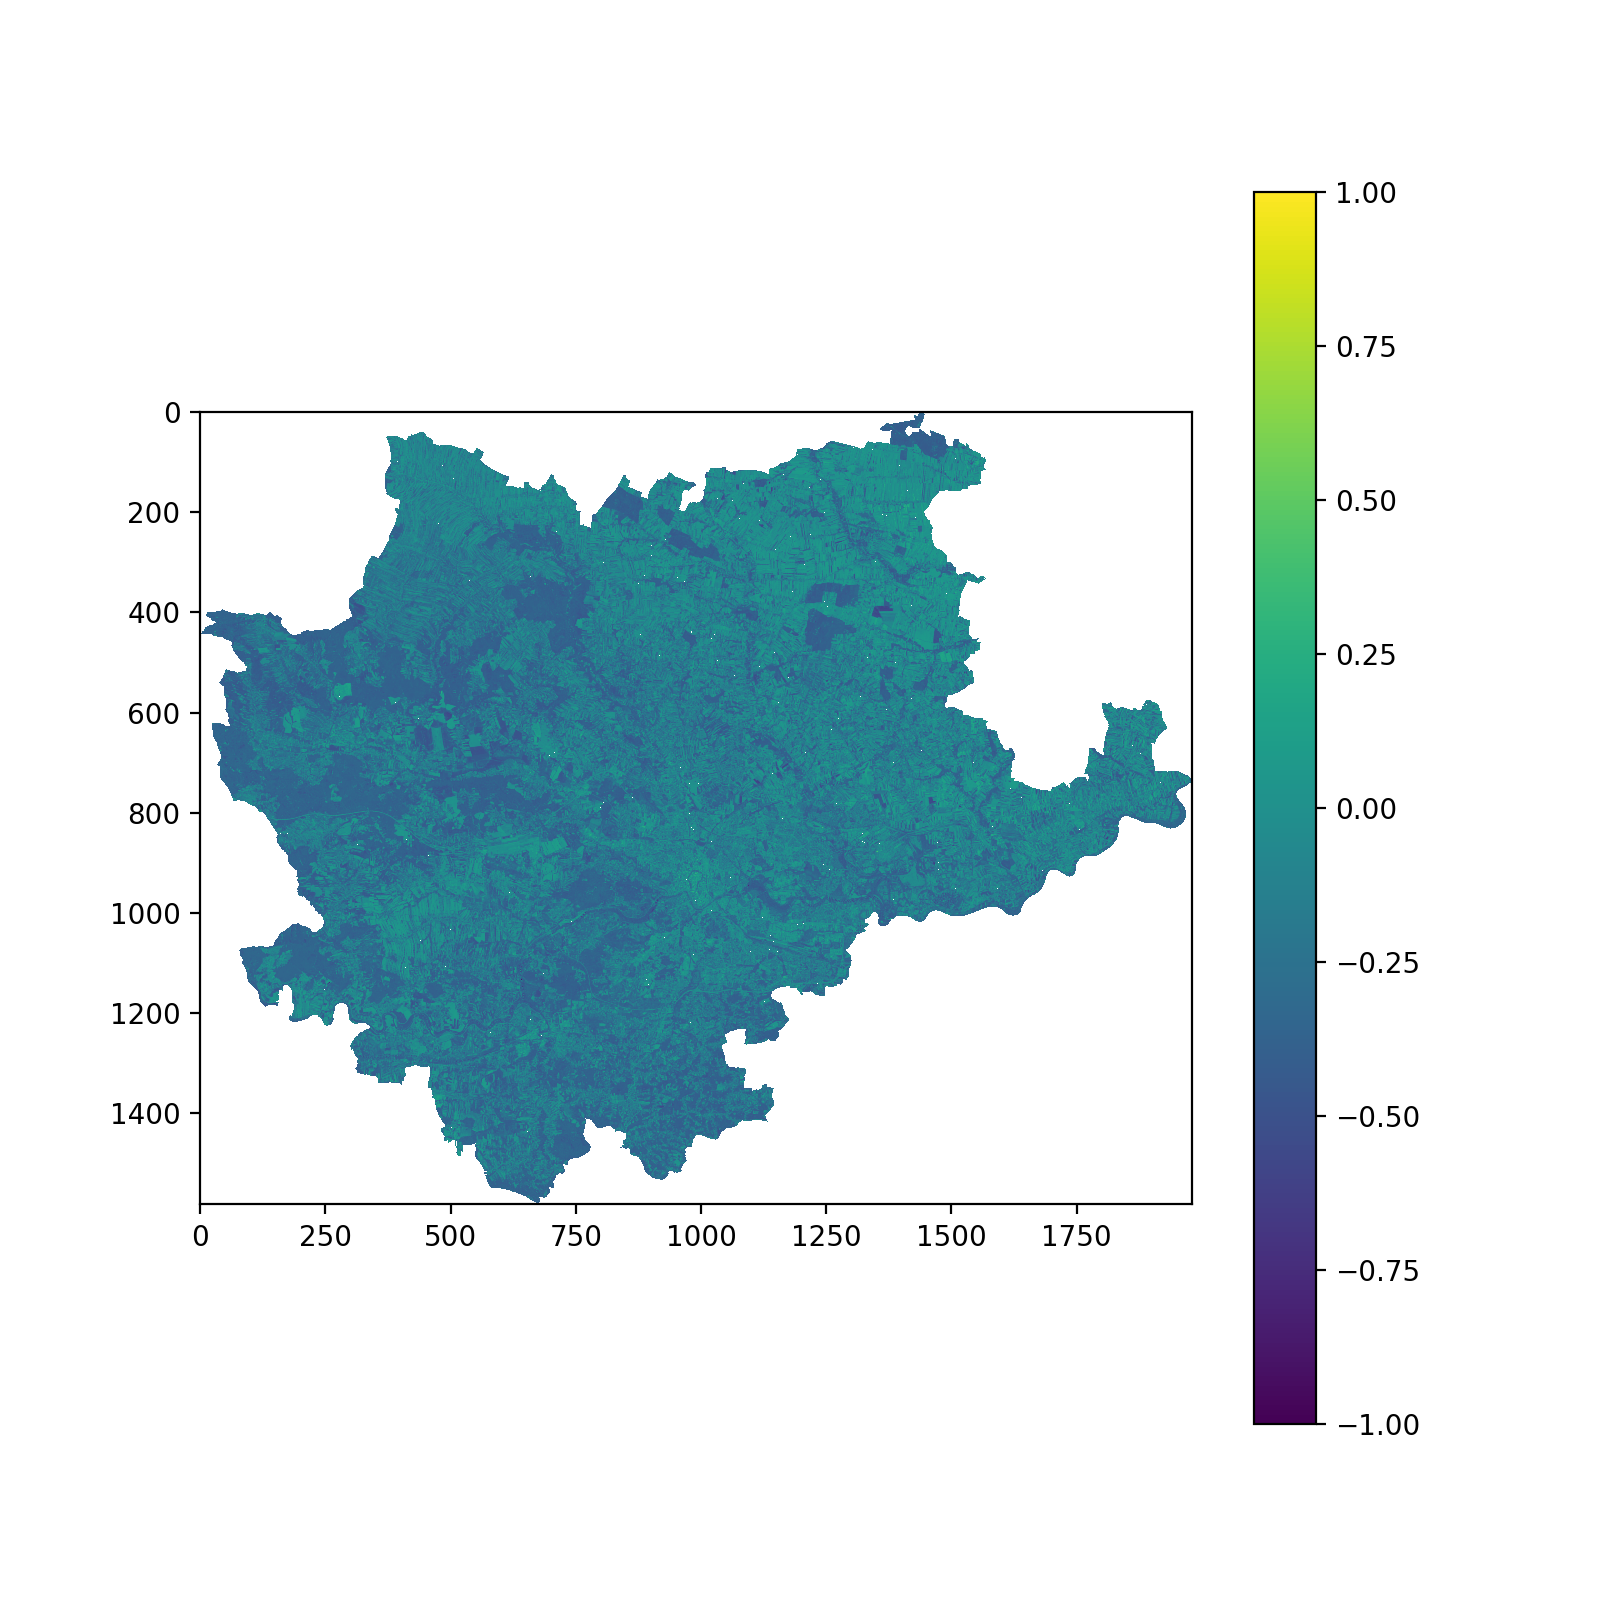

In [15]:
# 7. Oblicz NDBI

ndbi = calculate_index('ndbi', clipped_bands)
ndbi[ndbi == 0] = np.nan
show_band(ndbi, color_map='viridis', remove_negative=False)

<IPython.core.display.Javascript object>


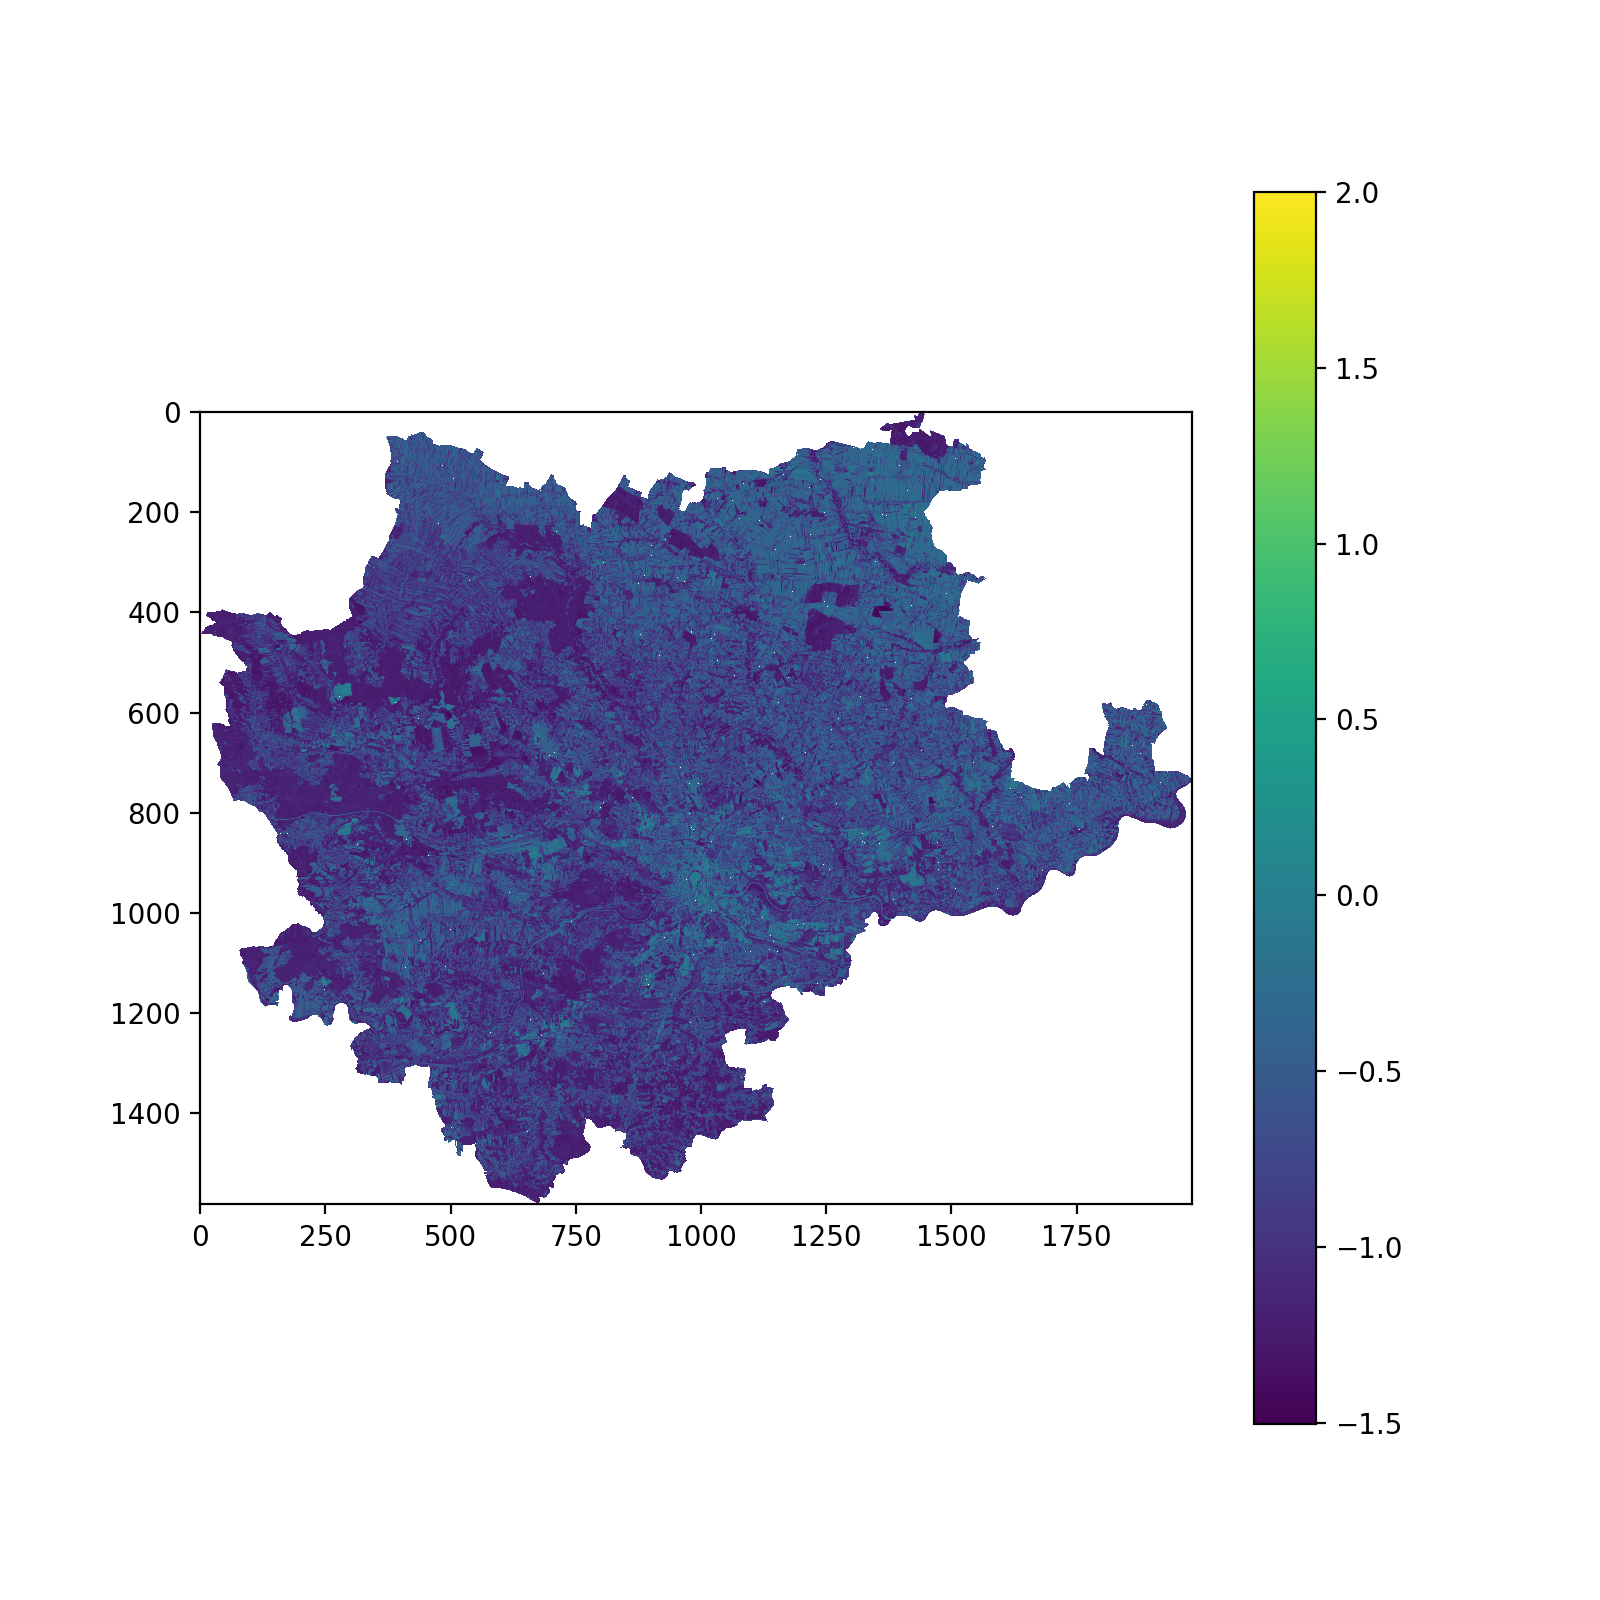

In [16]:
# 8. Różnica NDBI-NDVI

show_band(ndbi-ndvi, color_map='viridis', remove_negative=False)